In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from node2vec import Node2Vec
import numpy as np


In [ ]:
congress_path = "./congress.edgelist"
cora_cities_path = "./cora_cities.edgelist"
cora_congress_path = "./cora_congress.edgelist"
lastfm_path = "./lastfm_asia_edges.csv"


# Problem 1

In [ ]:
G = nx.read_edgelist(congress_path, create_using=nx.DiGraph())

hubs = {node: 1.0 for node in G.nodes()}
authorities = {node: 1.0 for node in G.nodes()}

num_iterations = 100

for _ in range(num_iterations):
    new_authorities = {node: 0.0 for node in G.nodes()}
    for node in G.nodes():
        for neighbor in G.predecessors(node):
            new_authorities[node] += hubs[neighbor]
    
    norm = sum(new_authorities.values())
    for node in new_authorities:
        new_authorities[node] /= norm
    
    new_hubs = {node: 0.0 for node in G.nodes()}
    for node in G.nodes():
        for neighbor in G.successors(node):
            new_hubs[node] += new_authorities[neighbor]
    
    norm = sum(new_hubs.values())
    for node in new_hubs:
        new_hubs[node] /= norm
    
    hubs = new_hubs
    authorities = new_authorities

In [22]:
pagerank = {node: 1.0 / len(G) for node in G.nodes()}

damping_factor = 0.85
num_iterations = 100

for _ in range(num_iterations):
    new_pagerank = {node: (1 - damping_factor) / len(G) for node in G.nodes()}
    for node in G.nodes():
        for neighbor in G.predecessors(node):
            new_pagerank[node] += damping_factor * pagerank[neighbor] / len(list(G.successors(neighbor)))
    
    pagerank = new_pagerank

print("PageRank:", pagerank)


PageRank: {'0': 0.0014221857769171776, '4': 0.0016717180114181759, '12': 0.0025564083777767565, '18': 0.0015808902789569543, '25': 0.002121580073908838, '30': 0.0014873905286593705, '46': 0.0024305905410555127, '55': 0.003286563400825805, '58': 0.0020260487847551857, '59': 0.0023446660837524967, '74': 0.002074294147876561, '76': 0.0010462669712270796, '77': 0.001571158698916755, '85': 0.0016279058254231153, '86': 0.0008629629930948454, '87': 0.0025879894320659873, '154': 0.002042519790553332, '168': 0.0006122223803133426, '341': 0.003110832588490571, '374': 0.003201586211551763, '401': 0.0050802548823515835, '3': 0.001330560541886976, '14': 0.0014078481551403868, '17': 0.0031814494329430953, '24': 0.0018291573979726675, '27': 0.0016032721007150051, '64': 0.001432433338611618, '79': 0.0018097211948223599, '84': 0.0013475720914156947, '88': 0.001629240930092342, '89': 0.0022695610564799087, '149': 0.003727702028249169, '179': 0.0020069282228779703, '197': 0.0038236159390925115, '213': 0.

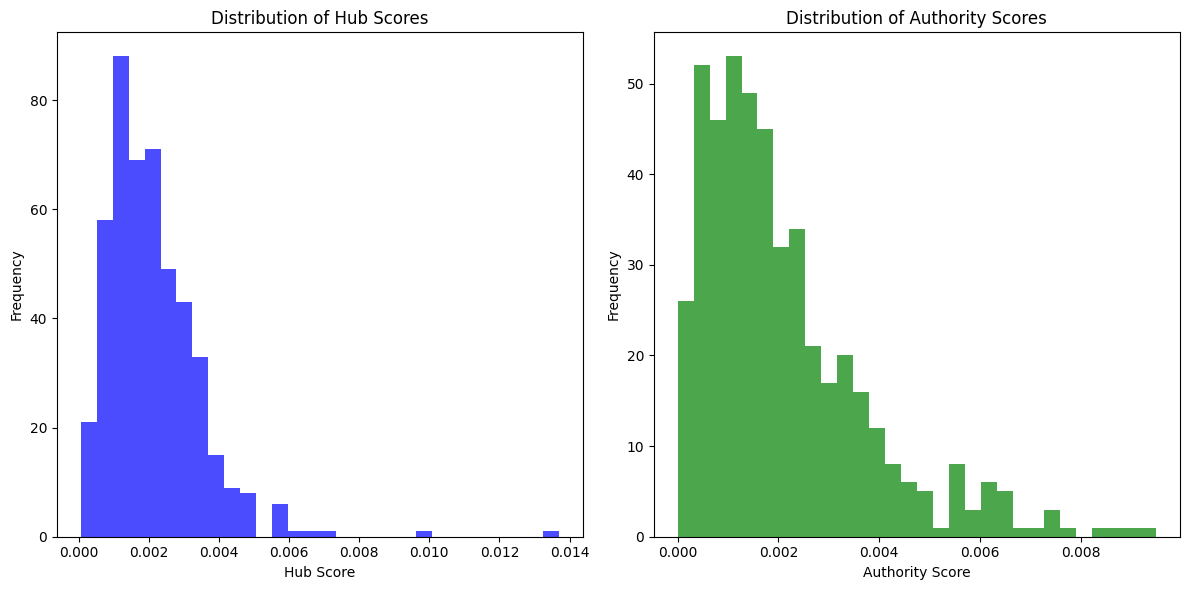

In [ ]:


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(hubs.values(), bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Hub Scores')
plt.xlabel('Hub Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(authorities.values(), bins=30, color='green', alpha=0.7)
plt.title('Distribution of Authority Scores')
plt.xlabel('Authority Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [24]:
from scipy.stats import pearsonr

hub_scores = list(hubs.values())
authority_scores = list(authorities.values())
pagerank_scores = list(pagerank.values())

hub_pagerank_corr, _ = pearsonr(hub_scores, pagerank_scores)
print("Pearson's correlation coefficient between hub scores and PageRank scores:", hub_pagerank_corr)

authority_pagerank_corr, _ = pearsonr(authority_scores, pagerank_scores)
print("Pearson's correlation coefficient between authority scores and PageRank scores:", authority_pagerank_corr)

Pearson's correlation coefficient between hub scores and PageRank scores: 0.5326410326963383
Pearson's correlation coefficient between authority scores and PageRank scores: 0.9632972714854122


Problem 2

In [ ]:
edges_df = pd.read_csv(lastfm_path)

lastfm_G = nx.Graph()

for index, row in edges_df.iterrows():
    lastfm_G.add_edge(row['node_1'], row['node_2'])

print(f"Number of nodes: {lastfm_G.number_of_nodes()}")
print(f"Number of edges: {lastfm_G.number_of_edges()}")

Number of nodes: 7624
Number of edges: 27806


In [26]:
def girvan_newman(G, threshold=0.90, iterations=25, percent_removed=0.01):
    G_copy = G.copy()
    best_communities = list(nx.connected_components(G_copy))
    best_modularity = nx.algorithms.community.quality.modularity(G, best_communities)
    modularity = 0
    for _ in range(iterations):   
        edge_betweenness = nx.edge_betweenness_centrality(G_copy, k=1000)
        
        edges_to_remove = sorted(edge_betweenness, key=edge_betweenness.get, reverse=True)[:int(len(edge_betweenness) * (percent_removed * (1 - modularity)))]

        G_copy.remove_edges_from(edges_to_remove)
                
        communities = list(nx.connected_components(G_copy))
        modularity = nx.algorithms.community.quality.modularity(G, communities)
        
        print(modularity)
        if modularity > best_modularity:
            best_modularity = modularity
            best_communities = communities
        
        if best_modularity >= threshold:
            break

    return best_communities, best_modularity

best_communities, best_modularity = girvan_newman(lastfm_G)

0.0004314102091292878
0.017607627661013404
0.01865901503656542
0.019905341159356292
0.11178757199631162
0.4602024512123949
0.4706458563209468
0.47137903639021644
0.47125252793798056
0.47346162550736526
0.4731484351853922
0.47345191682143695
0.6756073327880517
0.7135902555528937
0.7132387523622183
0.7131981515210382
0.7274037464722866
0.7272619122258844
0.7688546806580456
0.7686767322728526
0.7722646954040735
0.7722875330943126
0.7762758254473126
0.7765486470881167
0.7762100077607923


In [27]:
print(f"Number of communities: {len(best_communities)}")


Number of communities: 423


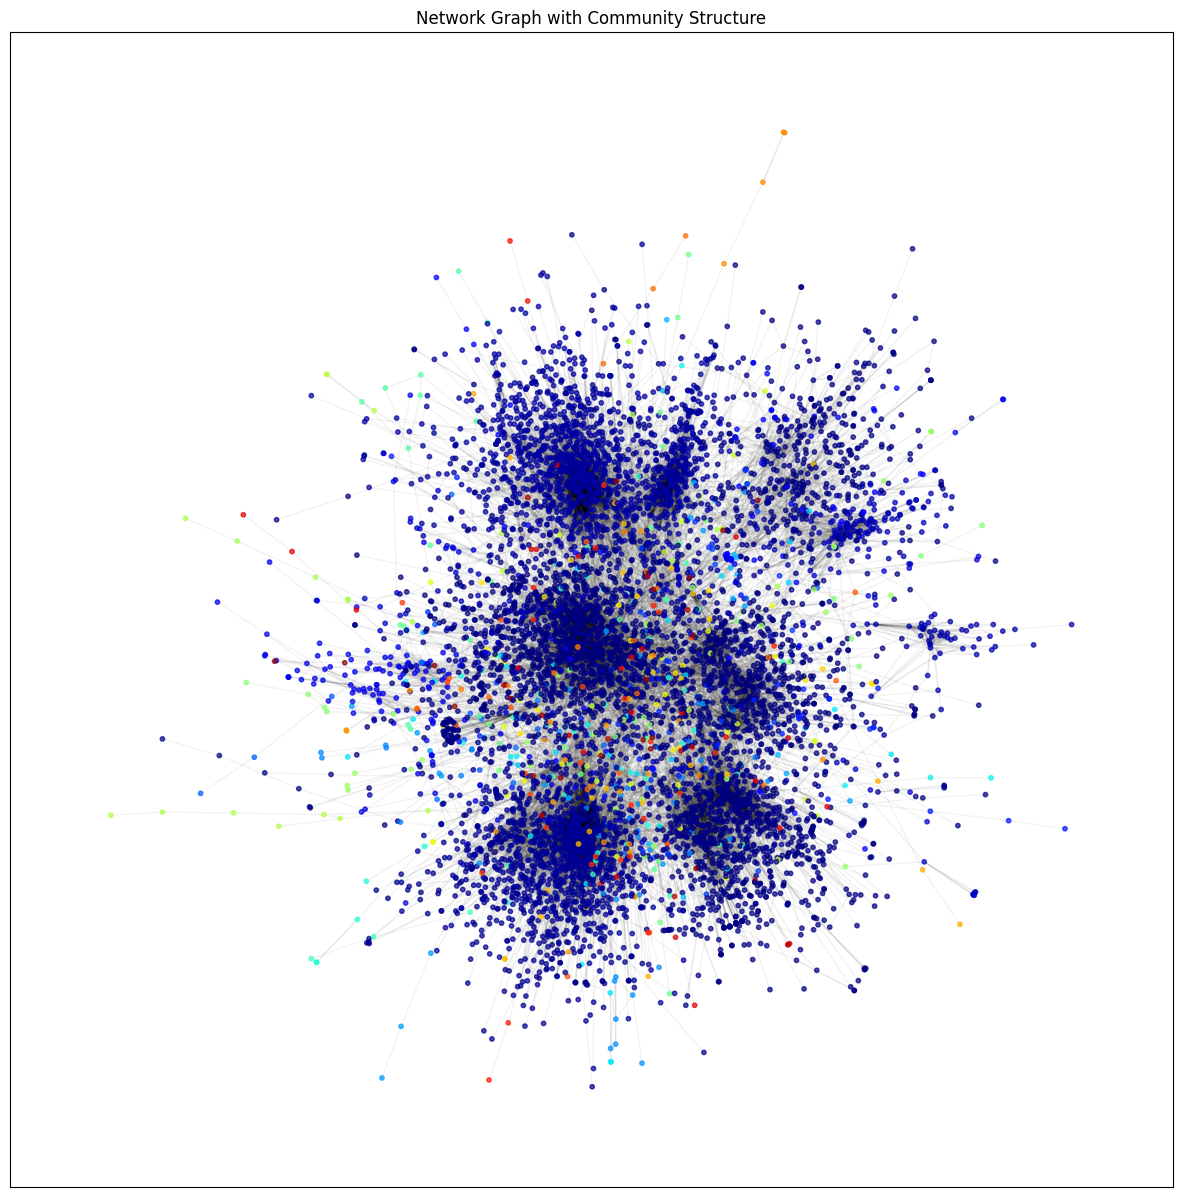

In [ ]:

plt.figure(figsize=(15, 15))

community_colors = {}
for i, community in enumerate(best_communities):
    for node in community:
        community_colors[node] = i

pos = nx.spring_layout(lastfm_G, seed=42)  # Or use a different layout if preferred

node_colors = [community_colors[node] for node in lastfm_G.nodes()]
nx.draw_networkx_nodes(lastfm_G, pos, node_size=10, node_color=node_colors, cmap=plt.cm.jet, alpha=0.7)

# Draw edges with transparency
nx.draw_networkx_edges(lastfm_G, pos, alpha=0.05)

plt.title("Network Graph with Community Structure")
plt.show()

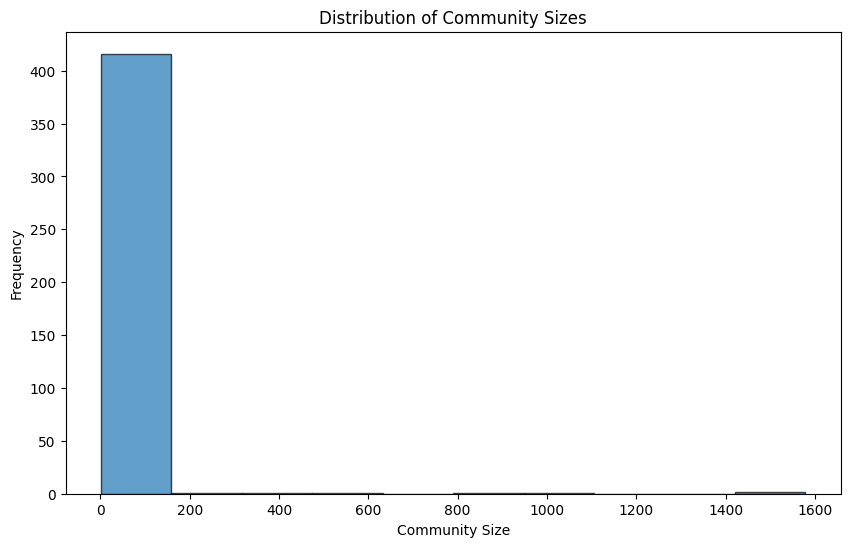

In [29]:
community_sizes = [len(community) for community in best_communities]

# Plot the distribution of community sizes
plt.figure(figsize=(10, 6))
plt.hist(community_sizes, edgecolor='black', alpha=0.7)
plt.xlabel("Community Size")
plt.ylabel("Frequency")
plt.title("Distribution of Community Sizes")
plt.show()


# Problem 3

In [ ]:

cites_file = "./cora.cites"
G = nx.read_edgelist(cites_file, create_using=nx.DiGraph(), nodetype=int)

content_file = "./cora.content"
content = pd.read_csv(content_file, sep='\t', header=None)
content.columns = ['node'] + [f'feat_{i}' for i in range(content.shape[1] - 2)] + ['label']
node_labels = content[['node', 'label']].set_index('node').to_dict()['label']

In [31]:
# Node 2 Vec and logistic regression
def node2vec_logregression(G, dimensions=128, l=80, r=10, p=1, q=1, k=10):

    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=l, num_walks=r, p=p, q=q, workers=4)
    model = node2vec.fit(window=k, min_count=1, batch_words=4)
    
    embeddings = {str(node): model.wv[str(node)] for node in G.nodes()}
    X = np.array([embeddings[str(node)] for node in G.nodes()])
    y = np.array([node_labels[node] for node in G.nodes()])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)

    return macro_f1, accuracy


In [32]:
marco_f1, accuracy = node2vec_logregression(G)
print(f"Macro F1 Score: {marco_f1}")
print(f"Accuracy: {accuracy}")

Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 38.05it/s]


Macro F1 Score: 0.2952217431634367
Accuracy: 0.4077490774907749


In [33]:
def plot_metric_vs_parameter(metric, parameter_values, parameter_name):
    plt.figure(figsize=(10, 6))
    plt.plot(parameter_values, metric, marker='o')
    plt.xlabel(parameter_name)
    plt.ylabel('Macro-F1 (Accuracy)')
    plt.title(f'Macro-F1 (Accuracy) vs {parameter_name}')
    plt.grid(True)
    plt.show()


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 61.41it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 63.37it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 66.16it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 68.57it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 65.08it/s]


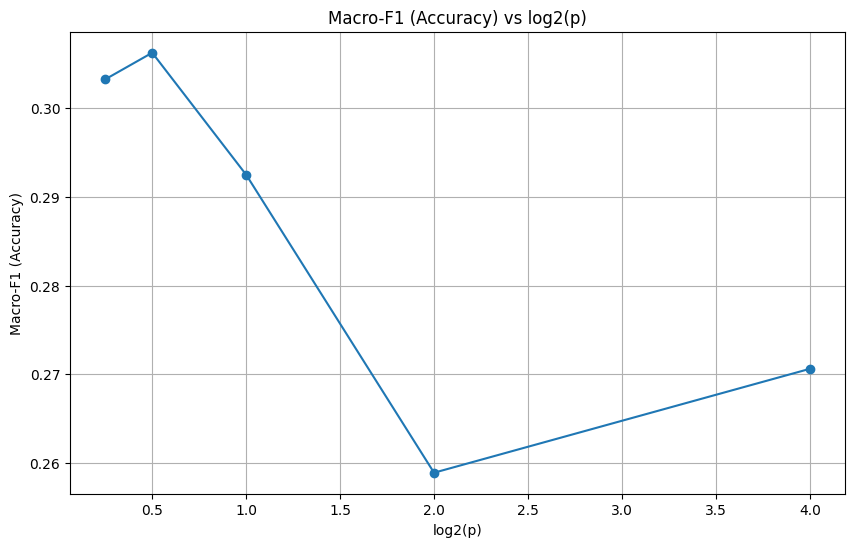

In [34]:
p_values = [0.25, 0.5, 1, 2, 4]
macro_f1_scores = []

for p in p_values:
    marco_f1, accuracy = node2vec_logregression(G, p=p)
    macro_f1_scores.append(marco_f1)

plot_metric_vs_parameter(macro_f1_scores, p_values, 'log2(p)')


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 65.23it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 66.20it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 43.68it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 67.30it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 61.82it/s]


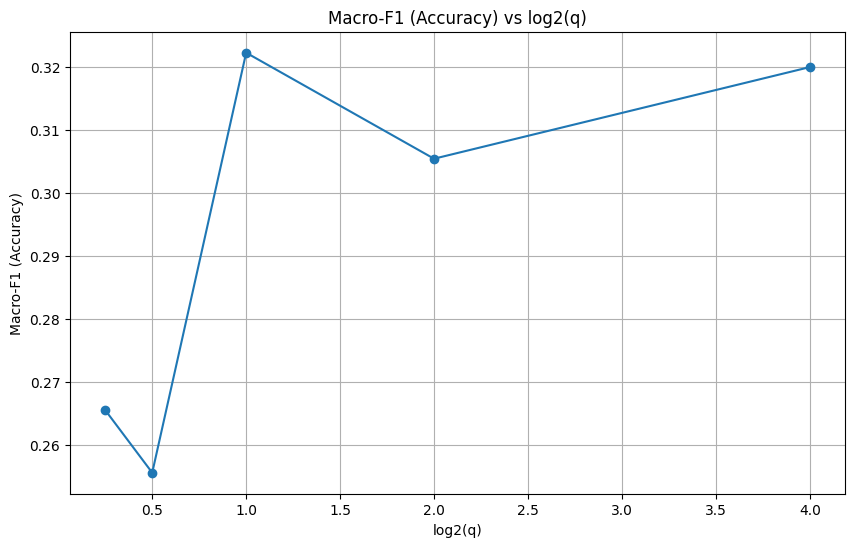

In [35]:
q_values = [0.25, 0.5, 1, 2, 4]
macro_f1_scores = []

for q in q_values:
    marco_f1, accuracy = node2vec_logregression(G, q=q)
    macro_f1_scores.append(marco_f1)

plot_metric_vs_parameter(macro_f1_scores, q_values, 'log2(q)')


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 64.51it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 64.10it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 66.99it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 66.99it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 68.41it/s]


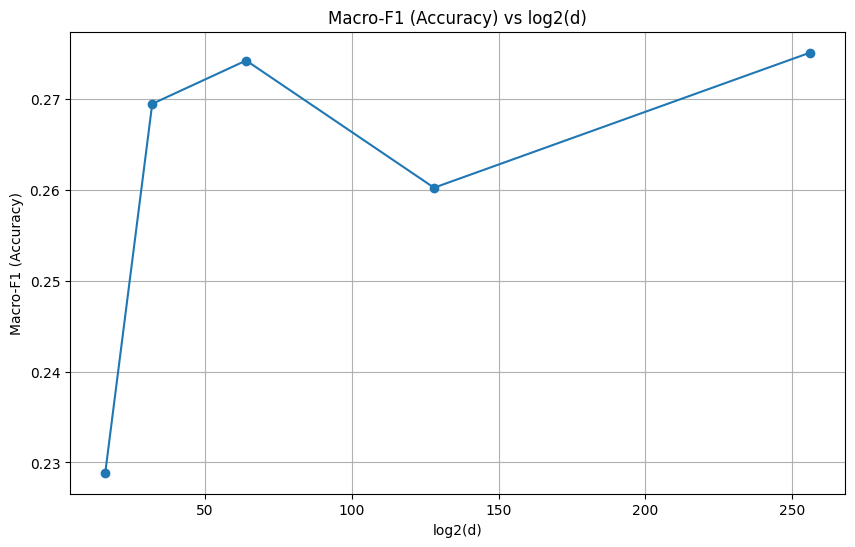

In [36]:
d_values = [16, 32, 64, 128, 256]
macro_f1_scores = []

for d in d_values:
    marco_f1, accuracy = node2vec_logregression(G, dimensions=d)
    macro_f1_scores.append(marco_f1)

plot_metric_vs_parameter(macro_f1_scores, d_values, 'log2(d)')


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 1/1 [00:00<00:00, 67.76it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 70.17it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 67.03it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 3/3 [00:00<00:00, 63.55it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 3/3 [00:00<00:00, 68.07it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 4/4 [00:00<00:00, 51.17it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 4/4 [00:00<00:00, 63.98it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00, 64.78it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 6/6 [00:00<00:00, 64.58it/s]


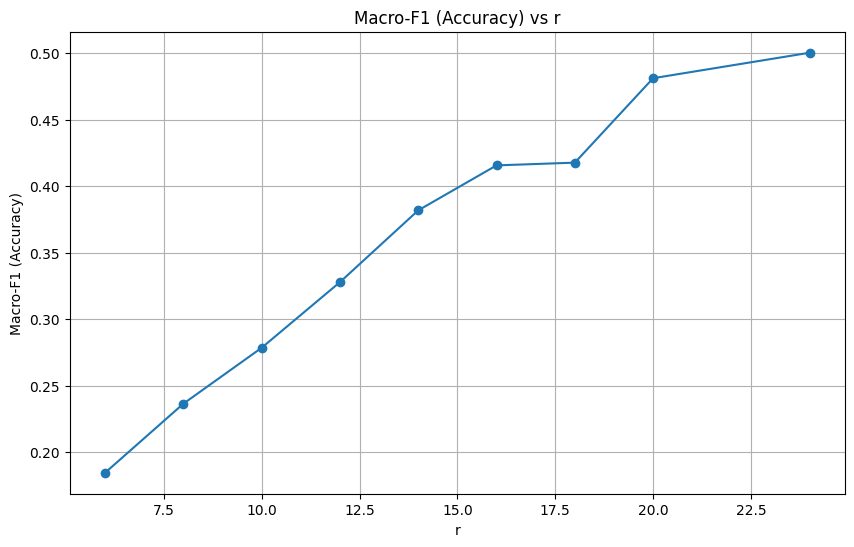

In [37]:
r_values = [6, 8, 10, 12, 14, 16, 18, 20, 24]
macro_f1_scores = []

for r in r_values:
    marco_f1, accuracy = node2vec_logregression(G, r=r)
    macro_f1_scores.append(marco_f1)

plot_metric_vs_parameter(macro_f1_scores, r_values, 'r')


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 101.68it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 88.19it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 80.50it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 73.28it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 60.98it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 59.84it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 56.98it/s]


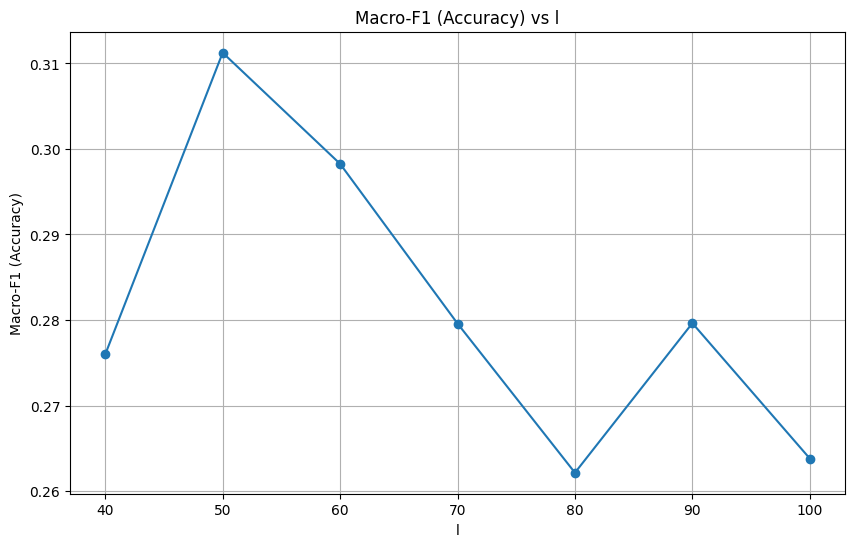

In [38]:
l_values = [40, 50, 60, 70, 80, 90, 100]
macro_f1_scores = []

for l in l_values:
    marco_f1, accuracy = node2vec_logregression(G, l=l)
    macro_f1_scores.append(marco_f1)

plot_metric_vs_parameter(macro_f1_scores, l_values, 'l')


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 65.17it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 66.19it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 61.93it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 58.38it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 39.45it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 65.38it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 64.16it/s]


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 65.46it/s]


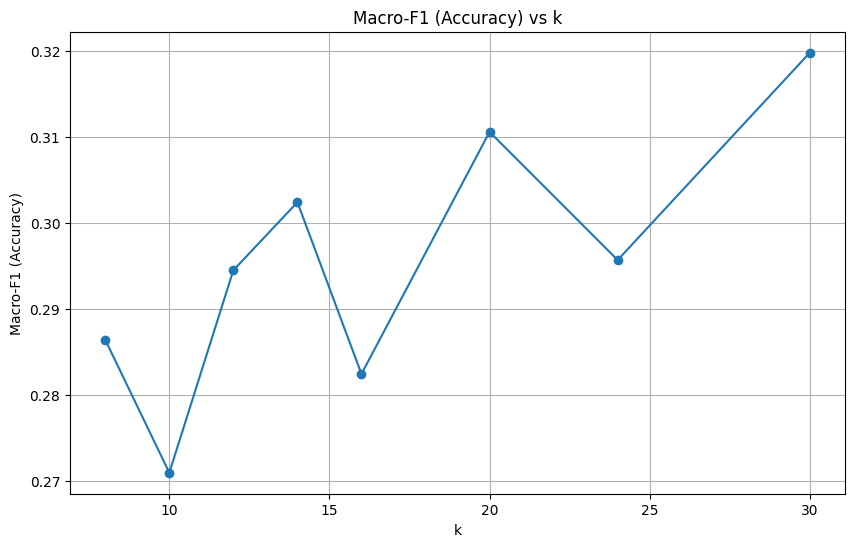

In [39]:
k_values = [8, 10, 12, 14, 16, 20, 24, 30]
macro_f1_scores = []

for k in k_values:
    marco_f1, accuracy = node2vec_logregression(G, k=k)
    macro_f1_scores.append(marco_f1)

plot_metric_vs_parameter(macro_f1_scores, k_values, 'k')
